### 1.实战练习
我们利用之前学习的内容来实战练习一个简单的Chat Bot，同时我们会实现一下简单的memory功能，即记录用户的历史对话。此处主要用到了 Reducer 函数。
主要的步骤：
1. 初始化LLM
2. 构建Graph
- 构建 state：state包含Schema和Reducer
- 构建Node
- 利用条件边创建循环
- 将Node连成Graph

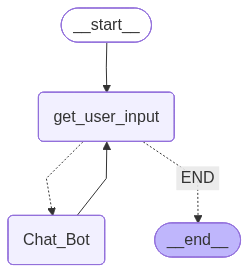

{'messages': [HumanMessage(content='退出', additional_kwargs={}, response_metadata={}, id='583835c2-2b41-4211-a382-d622fae76b38')]}

In [1]:
from typing import TypedDict, List, Annotated
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langchain_core.messages import AIMessage, AnyMessage, HumanMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
load_dotenv()

llm = init_chat_model(
    model="Qwen/Qwen3-8B",
    model_provider="openai",
    temperature=0.5,
)

# state的schema是AnyMessage的List，也就是可以装入任意类型的Message
# Annnotated就是我们实现为state指定Reducer的工具。Annotated后面的方括号中有两个参数，
# 第一个参数是我们的state的schema，第二个参数是我们的Reducer函数。
# 这里我们使用add_messages函数作为Reducer，它的作用是将新的Message添加到state的messages列表中。
class ChatState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]

# 构建Node的Function
# 用户输入获取节点
def get_user_input(state: ChatState) -> ChatState:
    """这个节点获取用户输入并添加到消息历史中"""
    user_input = input("用户: ")
    return {"messages": [HumanMessage(content=user_input)]}

# 机器人节点
def Chat_Bot(state: ChatState) -> ChatState:
    """这个节点调用LLM并将响应添加到消息历史中"""
    messages = state["messages"]
    response = llm.invoke(messages)
    print(f"\n机器人: {response.content}")
    return {"messages": [AIMessage(content=response.content)]}

# 利用条件边去构造循环
def should_continue(state: ChatState) -> str:
    """这个节点根据用户输入判断是否继续循环"""
    # 获取最后一条消息
    messages = state["messages"]
    last_message = messages[-1]
    if isinstance(last_message, HumanMessage) and last_message.content.lower() == "退出":
        return "END"
    return "Chat_Bot"

# 构建Graph
graph = StateGraph(ChatState)
# 添加节点
graph.add_node("Chat_Bot", Chat_Bot)
graph.add_node("get_user_input", get_user_input)
# 添加边
graph.add_edge(START, "get_user_input")
graph.add_conditional_edges(
    "get_user_input",
    should_continue,
    {
        "Chat_Bot": "Chat_Bot",
        "END": END,
    }
)
graph.add_edge("Chat_Bot", "get_user_input")
app = graph.compile()
# 可视化 Graph
display(Image(app.get_graph().draw_mermaid_png()))

app.invoke({"messages": []})
